1. [Imports](#imports)
2. [Understand](#under)
  1. [Simple Model Run](#initial)
3. [Exploratory Analysis](#explore)   
5. [Feature Engineering](#engineer)
6. [Algorithm Selection](#select)
6. [Hyperparameter Selection](#tune)
7. [Model Training](#train)

### Housing Prices with Ames Data Set 


Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

#### Exploratory Analysis
- Context of Data
- Start with Basics
- Plot Numerical Distributions
- Plot Categorical Distributions
- Plot Segmentations
- Study Correlations

#### Data Cleaning
 - Remove Unwanted observations
 - Fix Structural Errors
 - Filter Unwanted Outliers
 - Handle Missing Data
 
#### Feature Engineering
 - Infuse Domain Knowledge
 - Create Interaction Features
 - Combine Sparse Classes
 - Add Dummy Variables
 - Remove Unused Features

#### Algorithm Selection

#### Hyperparameter Selection

#### Model Training

##### Imports<a name="imports"></a>

In an attempt to keep things organized, the import statements (and some formatting statements) are grouped by function.  The my_utilities module includes cleaning and plotting functions stored outside the notebook for tidiness.  


In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.4f}'.format

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [3]:
import my_utilities as mut

In [149]:
# sklearn regressor
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, ParameterGrid

### Understand<a name="under"></a>
- try to develop a big picture understanding of the modeling task before investing significant time any specific part of the process.

In [5]:
file = 'AmesHousing/Data/train.csv'
df = pd.read_csv(file) 
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


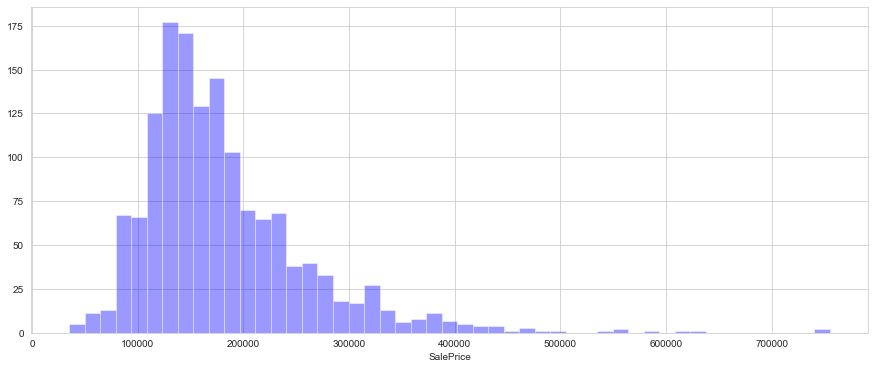

In [6]:
f, ax = plt.subplots(figsize=(15,6))
sns.distplot(df.SalePrice, color="b", kde = False,  ax=ax)
plt.show()

#### Process Features 0<a name="data"></a>
- clean columns labels
- classify features to categorical, numerical
- missing values

In [7]:
# load raw data and define categorical and numerical data
file = 'AmesHousing/Data/train.csv'
df0 = pd.read_csv(file) 
df0.columns = [mut.label_uncap_split(col) for col in df0.columns]
fte_cat = [col for col in df0.columns if df0[col].dtype == 'O']
fte_num = [col for col in df0.columns if not col in fte_cat]
fte_num.remove('id'); fte_num.remove('sale_price')

In [8]:
drop0 = ['sale_price', 'id']
X0 = df0.drop(drop0, axis=1)
y0 = df0['sale_price']
X_trn, X_tst, y_trn, y_tst = train_test_split( X0, y0, test_size=0.20, random_state=20)

In [9]:
# preprocessing
tfr_num = Pipeline(steps=[
    ('sir', SimpleImputer(strategy='constant', fill_value=0)),
    ('mms', MinMaxScaler())])
tfr_cat = Pipeline(steps=[
    ('sir', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
ppr = ColumnTransformer(transformers=[('num', tfr_num, fte_num),
                                      ('cat', tfr_cat, fte_cat)])

#### Simple model run<a name="initial"></a>
Run a simple model to help define our problem.  Maybe that is all that is needed. The results can guide the feature engineering process.  

In [10]:
est_ols = Pipeline(steps=[('ppr', ppr), ('est', LinearRegression())])
y_prd = est_ols.fit(X_trn, y_trn).predict(X_tst)
print("R Squared: %.4f" % r2_score( y_tst, y_prd))
print("Log Root Mean Square: %.4f" % mean_squared_log_error(y_tst,y_prd))

R Squared: 0.8777
Log Root Mean Square: 0.0281


Iniatially these are disappointedly good results (hoping it would more dificult). But plotting the residuals shows the estimator is quite poor, unsurprisingly in the target ranges where there there is less data.  And by a lucky coding discrepancy, there are some training test splits where the log of the root mean square can not be calculated as for lower range targets, the simple model predicts a negative value.  


The heat map demonstates some obvious issues with 

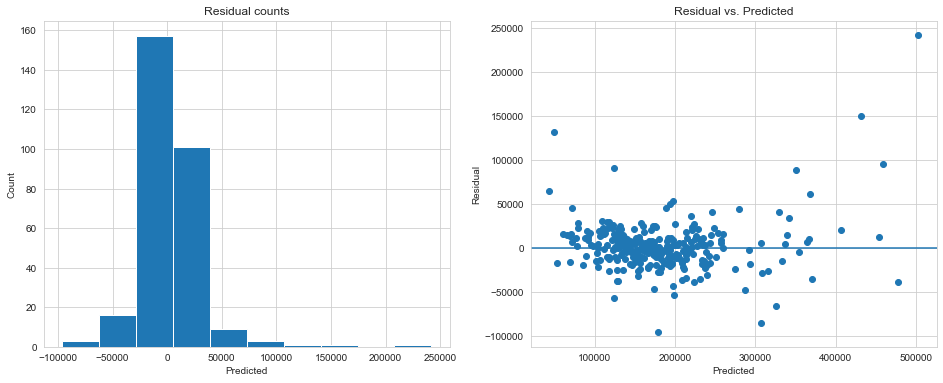

In [17]:
# Extract predicted values.

predicted = y_prd.ravel(); actual = y_tst
residual = actual - predicted
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

ax1.hist(residual)
ax1.set(ylabel='Count', xlabel='Predicted', title='Residual counts')
#ax1.title('Residual counts'); ax1.xlabel('Residual'); ax1.ylabel()
ax2.scatter(predicted, residual)
ax2.set(ylabel='Residual', xlabel='Predicted', title='Residual vs. Predicted')
ax2.axhline(y=0)

plt.show()

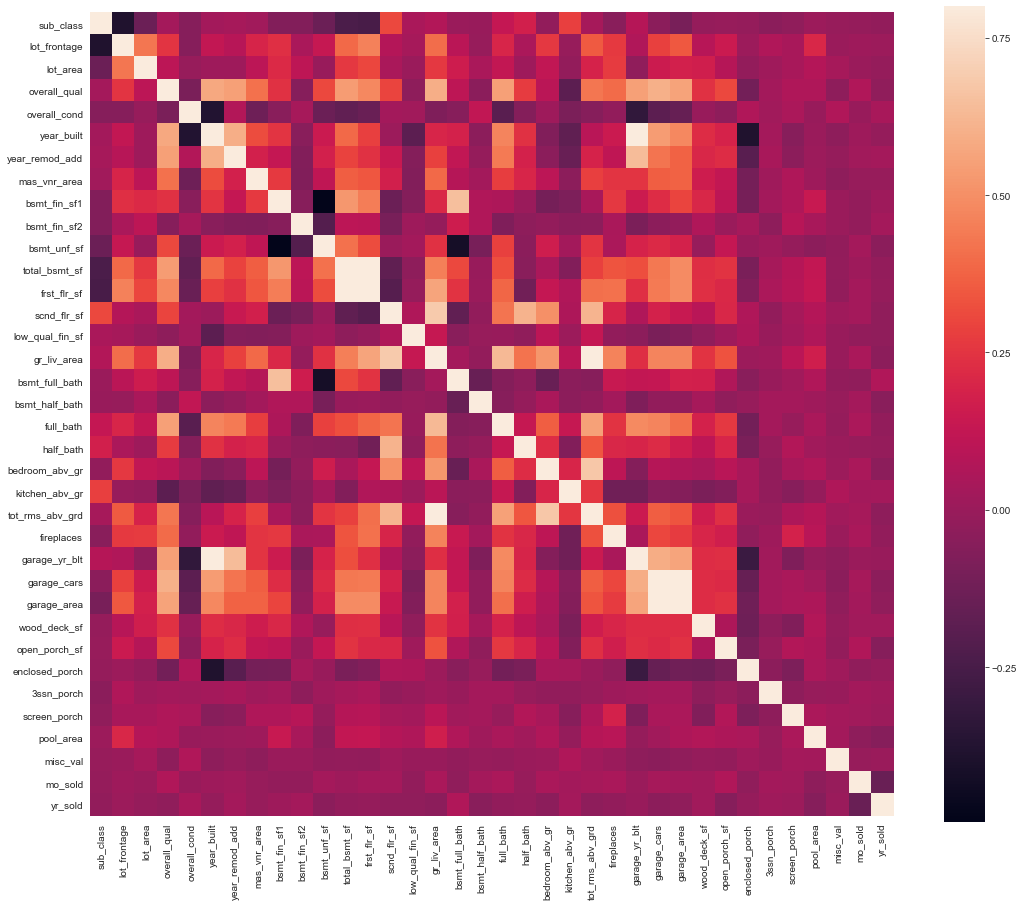

In [18]:
correlation_matrix = X0.corr()
f, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(correlation_matrix, vmax=.8, square=True)
plt.show()

#### Exploratory Analysis
 - Start with Basics
 - Context of Data
 - Plot Numerical Distributions
 - Plot Categorical Distributions
 - Plot Segmentations
 - Study Correlations

In [19]:
file = 'AmesHousing/Data/train.csv'
dfe = pd.read_csv(file) 
dfe.columns = [mut.label_uncap_split(col) for col in dfe.columns]

In [20]:
col_cat = [col for col in dfe.columns if dfe[col].dtype == 'O']
col_num = [col for col in dfe.columns if not col in col_cat]
col_nan = [col for col in dfe.columns if dfe[col].isna().any()]
col_ord = [col for col in col_num if len(dfe[col].unique()) <= 12]
col_num = list(set(col_num) - set(col_ord))

In [21]:
plot1 = [col for col in col_cat if (len(dfe[col].unique()) <= 8)]
plot2 = [col for col in col_cat if (len(dfe[col].unique()) > 8)]
plot2.remove('neighborhood')

In [28]:
for col in col_nan:
    if col in col_cat:
        dfe[col] = dfe[col].fillna('NA')
    else:
        dfe[col] = dfe[col].fillna(0)

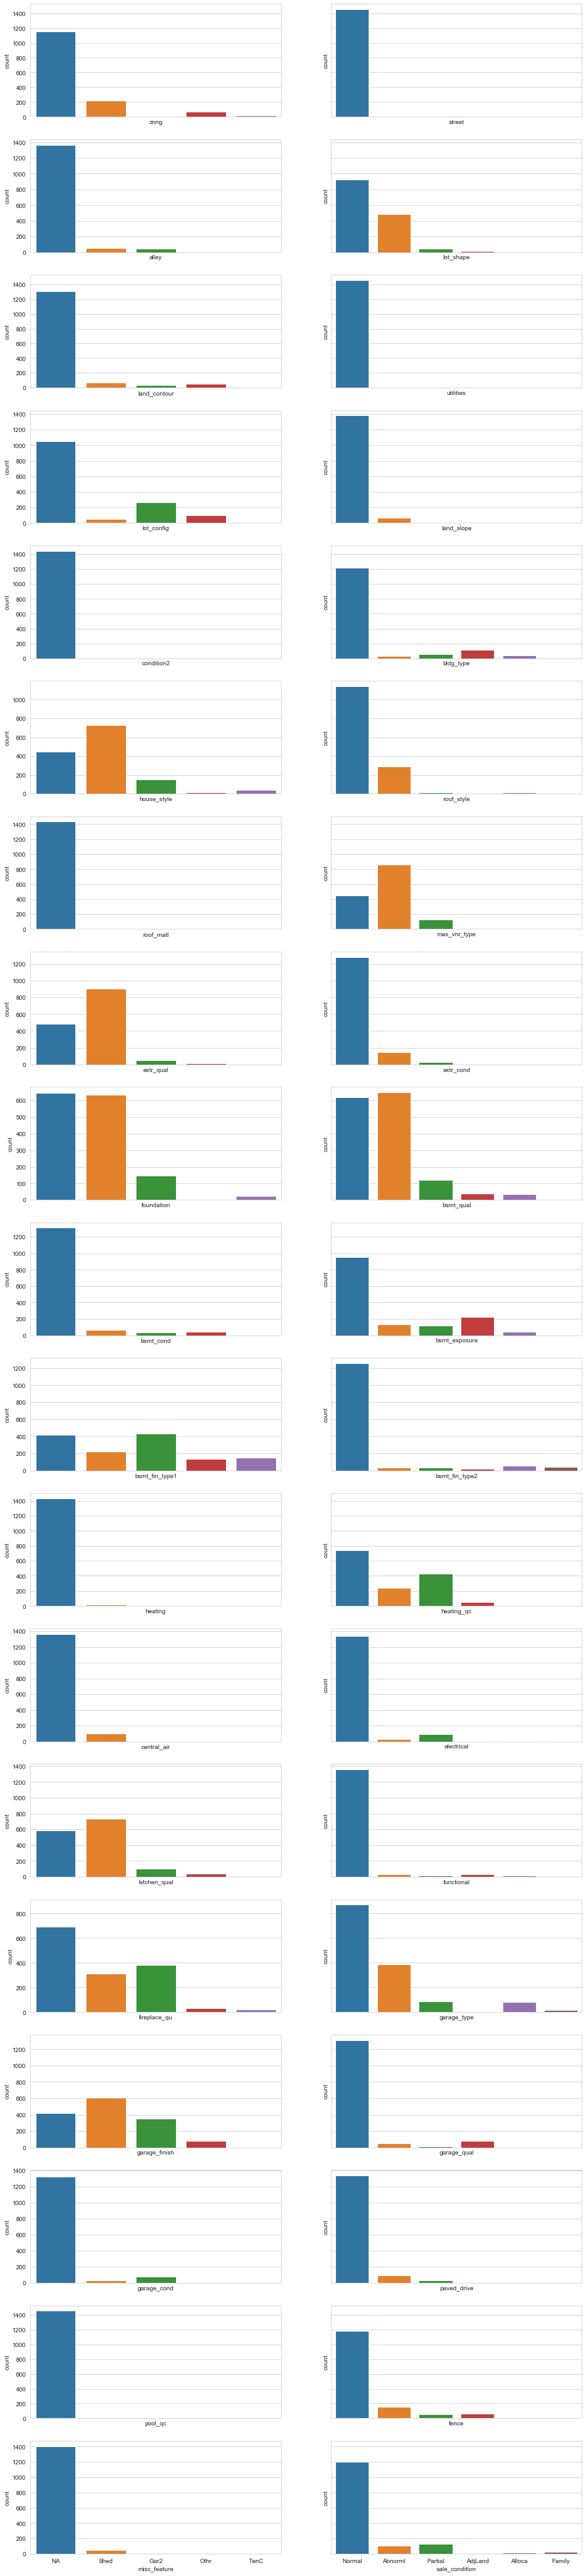

In [29]:
cols = 2
rows = len(plot1) // cols 
fig, axs = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(16, rows * 4))
i = 0
for x in range(rows):
    for y in range(cols):
        sns.countplot(x=plot1[i], data=dfe, ax=axs[x][y])     
        i += 1
plt.show()

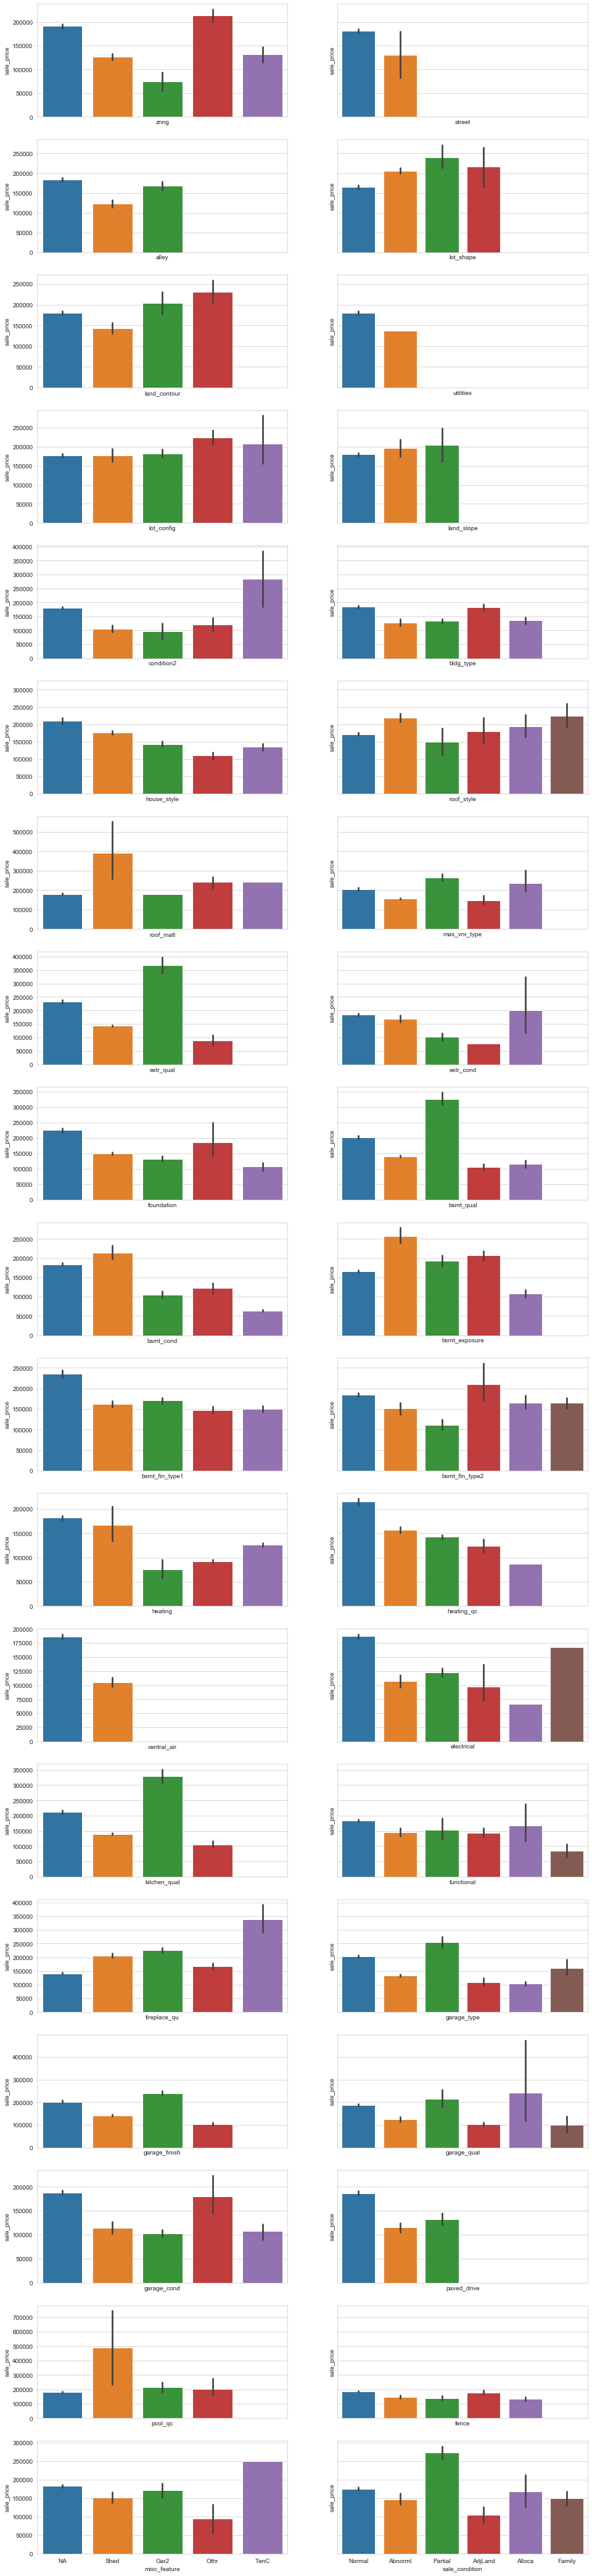

In [30]:
cols = 2
rows = len(plot1) // cols 
fig, axs = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(16, rows * 4))
i = 0
for x in range(rows):
    for y in range(cols):
        sns.barplot(x=plot1[i], y="sale_price", data=dfe, ax=axs[x][y])     
        i += 1
plt.show()

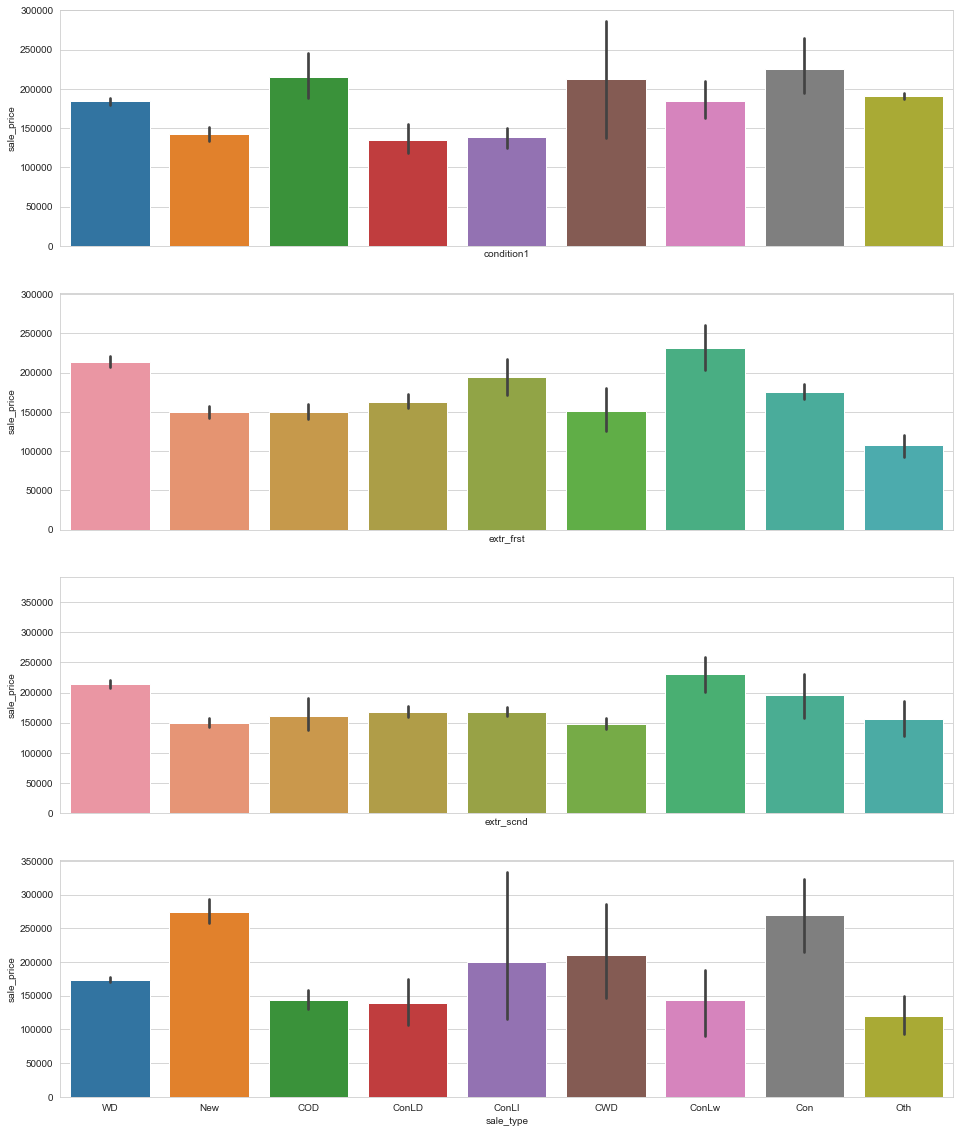

In [31]:
cols = 1
rows = len(plot2) // cols 
fig, axs = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(16, rows * 5))

for i in range( rows ):
        sns.barplot(x=plot2[i], y="sale_price", data=dfe, ax=axs[i])     
plt.show()

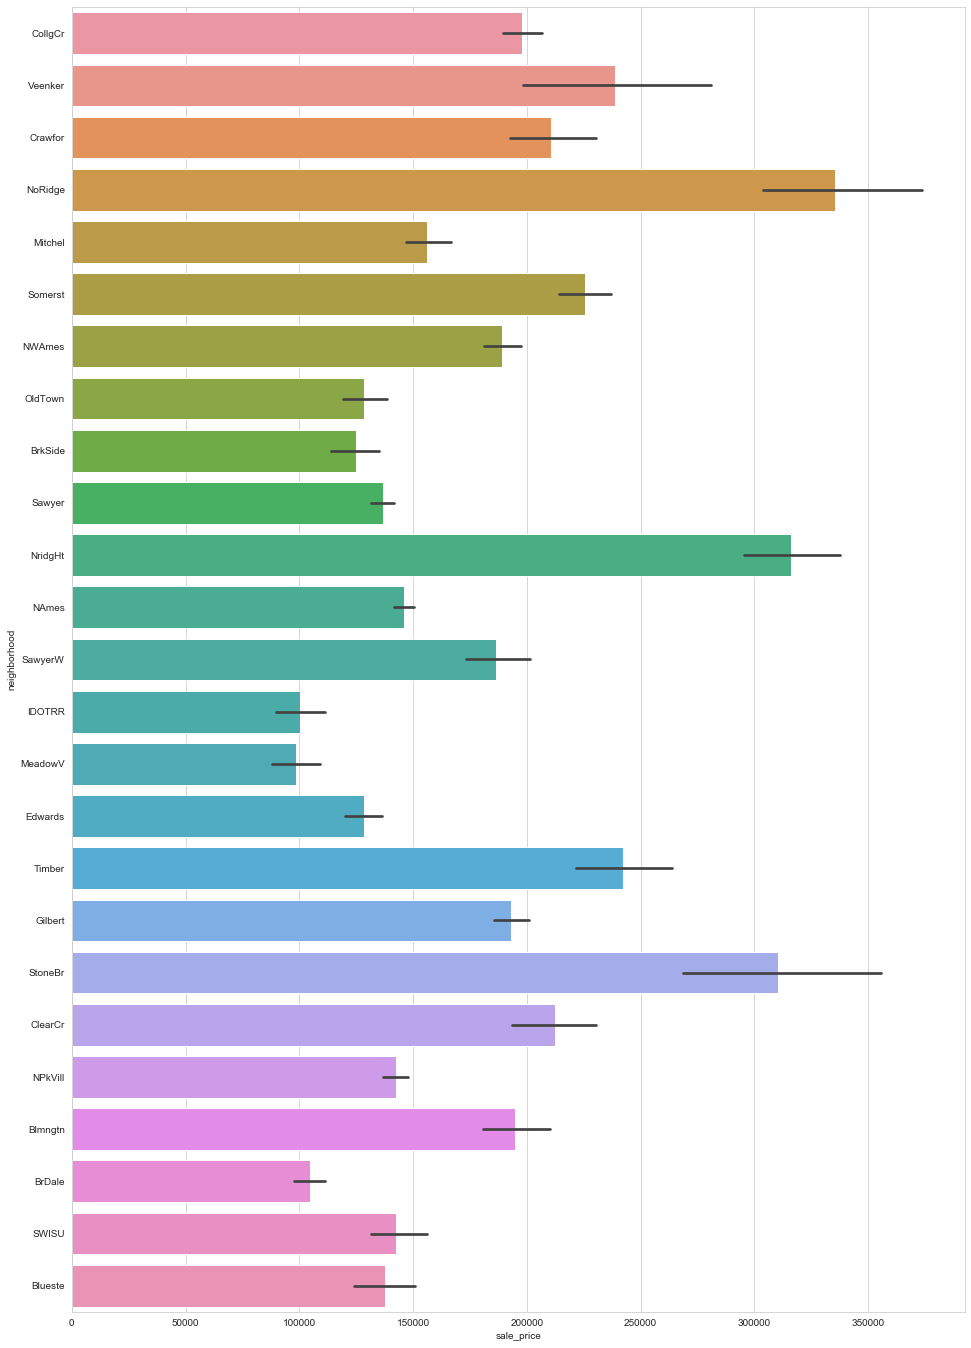

In [32]:
f, ax = plt.subplots(figsize=(16, 24))
sns.barplot(x="sale_price", y='neighborhood', data=dfe, orient='h', ax=ax)  
plt.show()

In [ ]:
cols = 2
rows = len(col_num) // cols 
fig, axs = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(16, rows * 5))
i = 0
for x in range(rows):
    for y in range(cols):
        sns.distplot(dfe[col_num[i]],  ax=axs[x][y])     
        i += 1
plt.show()

In [ ]:
#df.head()
#df.dtypes
#df.columns
#df.describe()
#uniq = {col:len(df[col].unique()) for col in df if col in col_obj}
#df.loc[np.where(df.mas_vnr_area.isna())]

### Development Lane

####  Feature Engineering<a name="engineer"></a>
 - correct misclassified features
 - transform features to ordinal where appropriate
 - add interaction feature to account for time related variance
 - acount for outliers in continuous features

In [112]:
file = 'AmesHousing/Data/train.csv'
df1 = pd.read_csv(file) 
df1.columns = [mut.label_uncap_split(col) for col in df1.columns]

In [113]:
#some initial sorting of the features
drop1 = drop0
fte_cat = [col for col in df1.columns if df1[col].dtype == 'O']
fte_flt = [col for col in df1.columns if df1[col].dtype == 'float64']
fte_int = [col for col in df1.columns if df1[col].dtype == 'int64']
fte_cts = fte_flt + fte_int
fte_nan = [col for col in df1.columns if df1[col].isna().any()]
fte_ord = [col for col in fte_cts if len(df1[col].unique()) <= 12]

In [114]:
# MSSubClass is categorical feature with integers for values.  change to letters to avoid confusion again
A = df1.sub_class.unique()
dct_scs = {A[i]:chr for (i, chr) in enumerate('ABCDEFGHIJKLMNO')}
df1.sub_class =  mut.fillna_transform_dct(df1.sub_class, dct_scs)
fte_cat.append('sub_class')

In [115]:
# ord_mth for variance across entire time period
# prices likely higher in June, does it vary from june 2006 to  2010
df1['ord_mth'] = (df1.yr_sold - 2006) * 12 + df1.mo_sold
fte_ord = fte_ord + ['ord_mth']; drop1 = drop1 + ['yr_sold', 'mo_sold']

In [116]:
# change from calender year to how many years from 2016
df1.garage_yr_blt  = 2016 - df1.garage_yr_blt
df1.year_built     = 2016 - df1.year_built
df1.year_remod_add = 2016 - df1.year_remod_add

In [117]:
# quality and condition ranks to match 1-10 scale for overall condition 
dct_ord = {'Ex':9,'Gd':7, 'TA':5, 'Fa':3, 'Po':2, 'NA':0}
fte_ord = ['overall_qual','overall_cond']
tfm_ord = ['bsmt_qual', 'bsmt_cond', 'extr_qual', 'extr_cond','heating_qc', 'garage_qual', 'garage_cond',
           'pool_qc', 'fireplace_qu']

for tfm in tfm_ord:
    df1[tfm] = mut.fillna_transform_dct(df1[tfm], dct_ord)
    fte_ord.append(tfm)  

In [118]:
# double check the classify feature lists
fte_cat = list(set(fte_cat) - set(fte_ord)) 
fte_cts = list(set(fte_cts) - set(fte_ord) -  set(fte_cat))
fte_cat = [fte for fte in fte_cat if not fte in drop1]
fte_cts = [fte for fte in fte_cts if not fte in drop1]
fte_ord = [fte for fte in fte_ord if not fte in drop1]

In [119]:
# preprocessing
tfr_cts = Pipeline(steps=[
    ('si0', SimpleImputer(strategy='constant', fill_value=0)),
    ('mms', StandardScaler())])
#('mms', MinMaxScaler())])
tfr_ord = Pipeline(steps=[
    ('si0', SimpleImputer(strategy='constant', fill_value=0)),
    ('ore', OrdinalEncoder(categories='auto'))])
tfr_cat = Pipeline(steps=[
    ('sin', SimpleImputer(strategy='constant', fill_value='NA', )),
    ('ohe', OneHotEncoder(handle_unknown='error'))])

pp1 = ColumnTransformer(
    transformers=[
        ('cts', tfr_cts, fte_cts),
        ('cat', tfr_cat, fte_cat),
        ('ord', tfr_ord, fte_ord)])

In [120]:
X1 = pp1.fit_transform(df1.drop(drop1, axis=1))
y1 = df1['sale_price']
#X_trn, X_tst, y_trn, y_tst = train_test_split( pp1.fit_transform(X1), y1, test_size=0.20, random_state=20)

#### Feature Engineering 2

 - combining / grouping features due to multicollinearity
 - combine the sparse classes
 - sparse categoricals to combined ordinals

In [134]:
drop2 = drop1

In [135]:
df1['bath'] = df1.half_bath * 2 + df1.full_bath * 4 + df1.bsmt_half_bath + df1.bsmt_full_bath
fte_cts.append('bath'); drop2 = drop2 + ['half_bath', 'full_bath', 'bsmt_half_bath', 'bsmt_full_bath']

In [136]:
# combine condition1 and condition2 into ordinal feature
dct_cdn = {'Artery':-3, 'Feedr':-1, 'Norm':0,'RRNn':-1, 'RRAn':-3, 'PosN':1, 'PosA':3,'RRNe':-1, 'RRAe':-3}
df1.condition1 = df1.condition1.apply(lambda x : dct_cdn[x])
df1.condition2 = df1.condition2.apply(lambda x : dct_cdn[x])
df1['cndn'] = df1.condition1 + df1.condition2
fte_ord.append('cndn'); drop2 = drop2 + ['condition1', 'condition2']

In [137]:
# account for variance in "low_qual_fin_sf" with ratio and delete redundent first and second floor areas
df1['gr_liv_qlty'] = (df1.gr_liv_area - df1.low_qual_fin_sf) / df1.gr_liv_area
fte_cts.append('gr_liv_qlty'); drop2 = drop2 + ['frst_flr_sf', 'scnd_flr_sf', 'low_qual_fin_sf']

In [138]:
df1['gar_cq'] = df1.garage_cond + df1.garage_qual

In [139]:
fte_ord.append('gr_liv_qlty'); drop2 = drop2 + ['garage_cond', 'garage_qual','garage_area' ]

In [140]:
df1['bmt_cq'] = df1.bsmt_cond + df1.bsmt_qual

In [141]:
dct_bmt = {'GLQ':20, 'ALQ':17, 'Unf':3, 'Rec':11, 'BLQ':14, 'NA':0, 'LwQ':7}
df1.bsmt_fin_type1 =  mut.fillna_transform_dct(df1.bsmt_fin_type1, dct_bmt)
df1.bsmt_fin_type2 =  mut.fillna_transform_dct(df1.bsmt_fin_type2, dct_bmt)

In [142]:
df1['bmt_ttl'] = (df1.bsmt_fin_type1 * df1.bsmt_fin_sf1 + 
                  df1.bsmt_fin_type2 * df1.bsmt_fin_sf2 + df1.bsmt_unf_sf * 3) // 20
                 

In [143]:
fte_ord.append('bmt_cq'); fte_ord.append('bmt_ttl')
drop2 = drop2 + ['bsmt_qual', 'bsmt_cond', 'bsmt_fin_type1', 'bsmt_fin_sf1',
                 'bsmt_fin_type2', 'bsmt_fin_sf2', 'bsmt_unf_sf','total_bsmt_sf']

In [144]:
fte_cat = [fte for fte in fte_cat if not fte in drop2]
fte_cts = [fte for fte in fte_cts if not fte in drop2]
fte_ord = [fte for fte in fte_ord if not fte in drop2]

In [145]:
pp2 = ColumnTransformer(
    transformers=[
        ('cts', tfr_cts, fte_cts),
        ('cat', tfr_cat, fte_cat),
        ('ord', tfr_ord, fte_ord)])

#### Algorithm Selection <a name="select"></a>

In [75]:
est_ols = LinearRegression()
est_rdg = Ridge()
est_ent = ElasticNet()
est_svr = SVR(gamma='auto')
est_krg = KernelRidge()
est_gbr = GradientBoostingRegressor()
est_rfr = RandomForestRegressor(n_estimators = 25)

note: est_ols and est_ent eliminated as it was returning negative values

In [130]:
est1s = [est_svr, est_rdg, est_krg, est_gbr, est_rfr]
scr1s = [cross_val_score(est, X1, y1, cv=4) for est in est1s]
prd1s = [cross_val_predict(est, X1, y1, cv=4) for est in est1s]

In [131]:
S_r1 = pd.Series([scr.mean() if i else 'NA' for (i,scr) in enumerate(scr1s)])
S_m1 = pd.Series([mean_squared_log_error(y1, prd) for (i,prd) in enumerate(prd1s)])
idx1 = [str(est) for est in est1s]
rslt1 = pd.DataFrame([S_r1, S_m1], index=['R_Squared','log_RMS']).T
rslt1.index = idx1 

In [132]:
rslt1

,R_Squared,log_RMS
"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',\n kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)",NA,0.1601
"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",0.8320,0.0297
"KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None)",0.8329,0.0295
"GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='ls', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_iter_no_change=None, presort='auto',\n random_state=None, subsample=1.0, tol=0.0001,\n validation_fraction=0.1, verbose=0, warm_start=False)",0.8928,0.0167
"RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=25,\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)",0.8498,0.0218


Continue with only the Gradient Boosting Regressor and Random Forest Resgressor

In [146]:
X2 = pp2.fit_transform(df1.drop(drop2, axis=1))
y2 = df1['sale_price']

In [147]:
est2s = [est_gbr, est_rfr]
scr2s = [cross_val_score(est, X2, y2, cv=4) for est in est2s]
prd2s = [cross_val_predict(est, X2, y2, cv=4) for est in est2s]

In [148]:
S_r2 = pd.Series([scr.mean() for (i,scr) in enumerate(scr2s)])
S_m2 = pd.Series([mean_squared_log_error(y2, prd) for (i,prd) in enumerate(prd2s)])
idx2 = [str(est) for est in est2s]
rslt2 = pd.DataFrame([S_r2, S_m2], index=['R_Squared','log_RMS']).T
rslt2.index = idx2

In [109]:
rslt2

,R_Squared,log_RMS
"GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,\n learning_rate=0.1, loss='ls', max_depth=3,\n max_features=None, max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=100,\n n_iter_no_change=None, presort='auto',\n random_state=None, subsample=1.0, tol=0.0001,\n validation_fraction=0.1, verbose=0, warm_start=False)",0.8822,0.0173
"RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, n_estimators=25,\n n_jobs=None, oob_score=False, random_state=None,\n verbose=0, warm_start=False)",0.8498,0.0211


#### Hyperparameter Selection<a name="tune"></a>


In [157]:
X1 = df1.drop(drop1, axis=1)
y1 = df1['sale_price']
X_trn, X_tst, y_trn, y_tst = train_test_split( pp1.fit_transform(X1), y1, test_size=0.20, random_state=20)

In [158]:
param_grid = {'n_estimators': [50, 100, 200],
              'loss': ['ls', 'lad', 'huber', 'quantile'],
              'min_samples_leaf': [1, 2,3],
              'max_depth':[2,3,4,5]}
prms =list(ParameterGrid(param_grid))
prds = [est_gbr.set_params(**prm).fit(X_trn,y_trn).predict(X_tst) for prm in prms]

In [180]:
S = pd.Series([mean_squared_log_error(y_tst, prd) for (i,prd) in enumerate(prds)])
rslt = pd.DataFrame([S], index=['log_RMS'])
tune = pd.concat([pd.Series(prm) for prm in prms], axis=1, sort=False).T
tune['log_rms'] = rslt.T.log_RMS

In [184]:
tune.loc[24:28]

,loss,max_depth,min_samples_leaf,n_estimators,log_rms
24,ls,4,3,50,0.0157
25,ls,4,3,100,0.0139
26,ls,4,3,200,0.0133
27,ls,5,1,50,0.0162
28,ls,5,1,100,0.0151


In [190]:
param_grid = {'n_estimators': [200, 300, 500],
              'loss': ['ls'],
              'min_samples_leaf': [3,4],
              'max_depth':[4]}
prms =list(ParameterGrid(param_grid))
prds = [est_gbr.set_params(**prm).fit(X_trn,y_trn).predict(X_tst) for prm in prms]

In [191]:
S = pd.Series([mean_squared_log_error(y_tst, prd) for (i,prd) in enumerate(prds)])
rslt = pd.DataFrame([S], index=['log_RMS'])
tune = pd.concat([pd.Series(prm) for prm in prms], axis=1, sort=False).T
tune['log_rms'] = rslt.T.log_RMS

In [192]:
tune

,loss,max_depth,min_samples_leaf,n_estimators,log_rms
0,ls,4,3,200,0.0132
1,ls,4,3,300,0.0132
2,ls,4,3,500,0.0135
3,ls,4,4,200,0.0139
4,ls,4,4,300,0.0141
5,ls,4,4,500,0.0140


#### Model Training<a name="train"></a>

In [ ]:
mdl - 